## Using the bmtool spike analysis module
By Gregory Glickert

In [41]:
from bmtool.analysis.spikes import load_spikes_to_df, get_population_spike_rate, compute_firing_rate_stats, average_spike_rate_over_windows
from bmtool.bmplot.spikes import raster, plot_firing_rate_pop_stats, plot_firing_rate_distribution
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## load_spikes_df
We can use the load_spikes_df to load our network output into a dataframe. It can also be useful to provide the config for the network so we can see which population the cells come from.

In [42]:
config_path = '/home/gjgpb9/cortex_modeling/V1_Layer5/Model-Parameters/simulation_config_baseline.json'
output_path = '/home/gjgpb9/cortex_modeling/V1_Layer5/Run-Storage/final_result_2/block1/long/spikes.h5'

df = load_spikes_to_df(spike_file=output_path,network_name='cortex',config=config_path)
df

,node_ids,timestamps,pop_name
0,8622,7.1,FSI
1,9477,7.3,LTS
2,9903,7.7,LTS
3,9300,8.4,FSI
4,3791,9.0,CP
...,...,...,...
464167,9864,14499.6,LTS
464168,9681,14499.6,LTS
464169,1890,14499.6,CP
464170,6613,14499.7,CS


You can actually have the function label the spikes with any attribute that is there when you build the nodes. By default it is pop_name but you could do anything. So if your build looks like this.

```python
net.add_nodes(N=n_I, pop_name='PV',     # N = number of inhibitory cells
        model_type='biophysical',
        model_template='hoc:WBInhCell',  # WBInhCell hoc definition
        morphology='blank.swc',
        positions = positions_cuboid(N=n_I,center=[0.,0.,0.],xside_length=10.,yside_length=10.,height=10.,min_dist=2))
```
You could use, N,pop_name,model_type,model_template,morphology,and position to label the cells. For this example N and positions would be poor choices to label due to being unique for every cell.

In [43]:
df = load_spikes_to_df(output_path,network_name='cortex',config=config_path,groupby=['model_template','pop_name'])
df

,node_ids,timestamps,model_template,pop_name
0,8622,7.1,hoc:FSI_Cell,FSI
1,9477,7.3,hoc:LTS_Cell,LTS
2,9903,7.7,hoc:LTS_Cell,LTS
3,9300,8.4,hoc:FSI_Cell,FSI
4,3791,9.0,hoc:CP_Cell,CP
...,...,...,...,...
464167,9864,14499.6,hoc:LTS_Cell,LTS
464168,9681,14499.6,hoc:LTS_Cell,LTS
464169,1890,14499.6,hoc:CP_Cell,CP
464170,6613,14499.7,hoc:CS_Cell,CS


This can be helpful if you have nodes with the same pop_name, but different layers so you may want more than one label to tell which cells are spiking.


## raster plot
You may want a way to look at the spikes to see when they are firing. One way to do this is by a raster plot

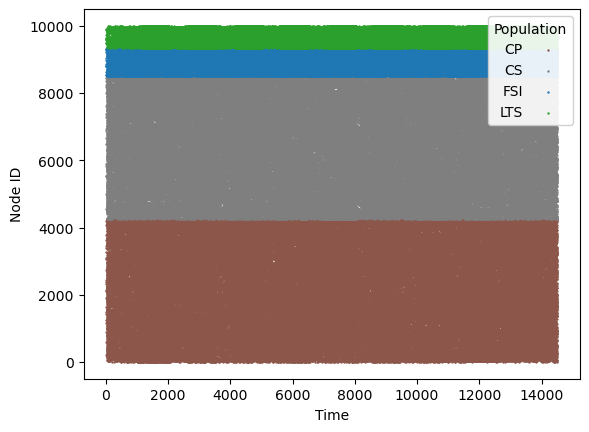

In [44]:
raster(spikes_df=df)
plt.show()

You can also play with some settings in the raster function if you want to view the data better or in a different way.

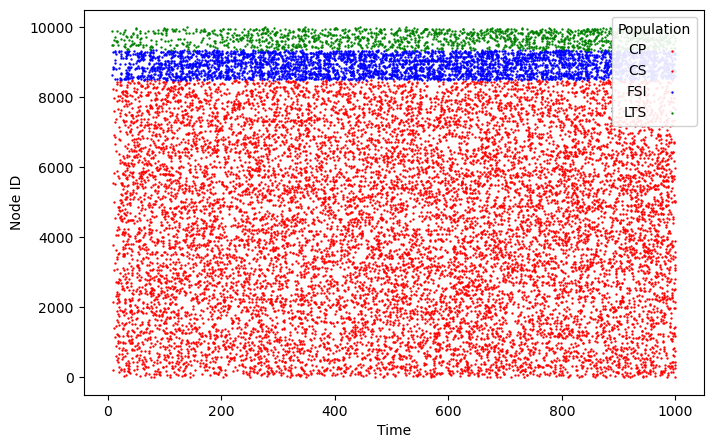

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

color_map = {
    'CS': 'red',
    'CP': 'red', 
    'FSI': 'blue', 
    'LTS': 'green'
}

raster(spikes_df=df,ax=ax,
       groupby='pop_name',
       color_map=color_map,
       tstart=0,tstop=1000)
plt.show()

## Spike Rate
There is also a population spike rate function. This can turn your dataframe into a time series, which can then be futher analyzed.

In [46]:
df = load_spikes_to_df(output_path,network_name='cortex',config=config_path)
spike_rate = get_population_spike_rate(df,config=config_path,network_name='cortex')
display(spike_rate)

<xarray.DataArray (time: 5800, population: 4, type: 2)>
array([[[0.        , 1.4118588 ],
        [0.        , 0.88750121],
        [0.        , 0.78587889],
        [0.        , 0.72381333]],

       [[0.        , 1.42681938],
        [0.        , 0.8934122 ],
        [0.        , 0.79454548],
        [0.        , 0.73308296]],

       [[0.47058824, 1.45641973],
        [0.61538462, 0.90502934],
        [0.        , 0.81154425],
        [0.        , 0.75131488]],

       ...,

       [[2.35294118, 3.74999671],
        [4.30769231, 3.12395504],
        [1.03529412, 1.54630566],
        [1.78823529, 1.6247682 ]],

       [[2.82352941, 3.73754173],
        [3.69230769, 3.14184906],
        [1.69411765, 1.54911239],
        [1.69411765, 1.62555177]],

       [[4.23529412, 3.73125568],
        [6.15384615, 3.15105916],
        [1.97647059, 1.55052619],
        [1.31764706, 1.62596401]]])
Coordinates:
  * time        (time) float64 0.0 2.5 5.0 7.5 ... 1.449e+04 1.45e+04 1.45e+04
  * population  (population) object 'FSI' 'LTS' 'CP' 'CS'
  * type        (type) <U8 'raw' 'smoothed'
Attributes:
    fs:             400.0
    normalized:     False
    smooth_method:  gaussian
    smooth_window:  50

You can plot the data as well. This example just uses the simple plotting built into an xarray, but you ca also plot it with matplotlib.

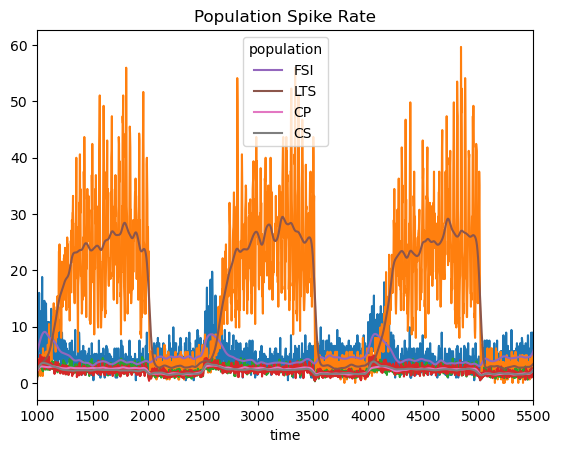

In [47]:
spike_rate.sel(type='raw').plot(hue='population')
spike_rate.sel(type='smoothed').plot(hue='population')
plt.title('Population Spike Rate')
plt.xlim(1000, 5500)
plt.show()

## Averaging the data
You can also average the data across several windows of time.

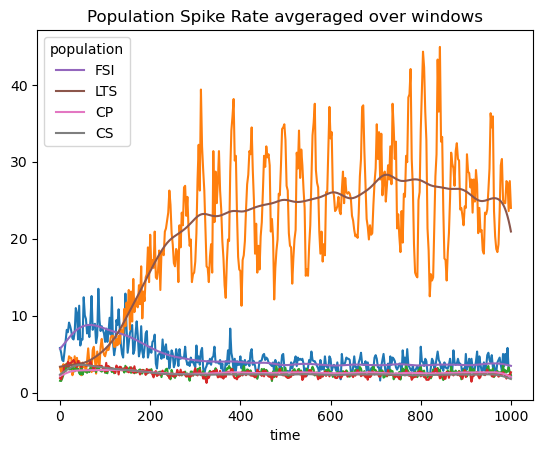

In [48]:
pulse_times = [(1000,2000), (2500,3500), (4000,5000)]
spike_rate_avg = average_spike_rate_over_windows(spike_rate, pulse_times)
spike_rate_avg.sel(type='raw').plot(hue='population')
spike_rate_avg.sel(type='smoothed').plot(hue='population')
plt.title('Population Spike Rate avgeraged over windows')
plt.show()

## Firing rate stats
You can easily get some firing rate stats and plot them using the below functions 

In [49]:
df = load_spikes_to_df(output_path, network_name="cortex", config=config_path,groupby=['model_template','pop_name'])
pop_stats,indivdual_stats = compute_firing_rate_stats(df, groupby=['model_template','pop_name'])
display(indivdual_stats)
display(pop_stats)

,node_ids,spike_count,model_template,pop_name,firing_rate
0,9848,852,hoc:LTS_Cell,LTS,58.787812
1,8541,707,hoc:FSI_Cell,FSI,48.782844
2,9430,617,hoc:LTS_Cell,LTS,42.572864
3,8527,617,hoc:FSI_Cell,FSI,42.572864
4,9214,558,hoc:FSI_Cell,FSI,38.501877
...,...,...,...,...,...
9986,7224,1,hoc:CS_Cell,CS,0.069000
9987,8315,1,hoc:CS_Cell,CS,0.069000
9988,8980,1,hoc:FSI_Cell,FSI,0.069000
9989,9341,1,hoc:FSI_Cell,FSI,0.069000


,model_template,pop_name,firing_rate_mean,firing_rate_std
0,hoc:CP_Cell,CP,2.210251,1.516544
1,hoc:CS_Cell,CS,2.173785,1.428758
2,hoc:FSI_Cell,FSI,4.494283,5.867914
3,hoc:LTS_Cell,LTS,14.776037,7.553584


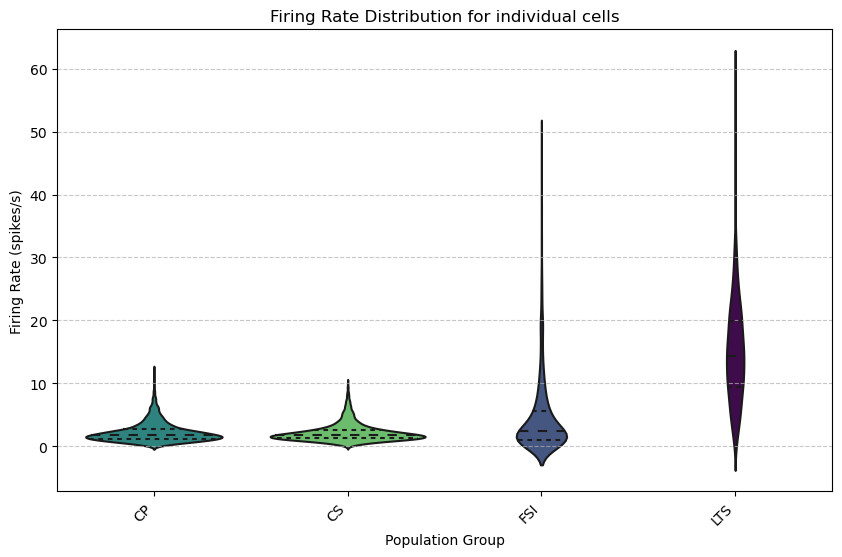

In [50]:
plot_firing_rate_distribution(indivdual_stats,groupby='pop_name',plot_type='violin') # type can be box,swarm,violin or a combo 
plt.show()

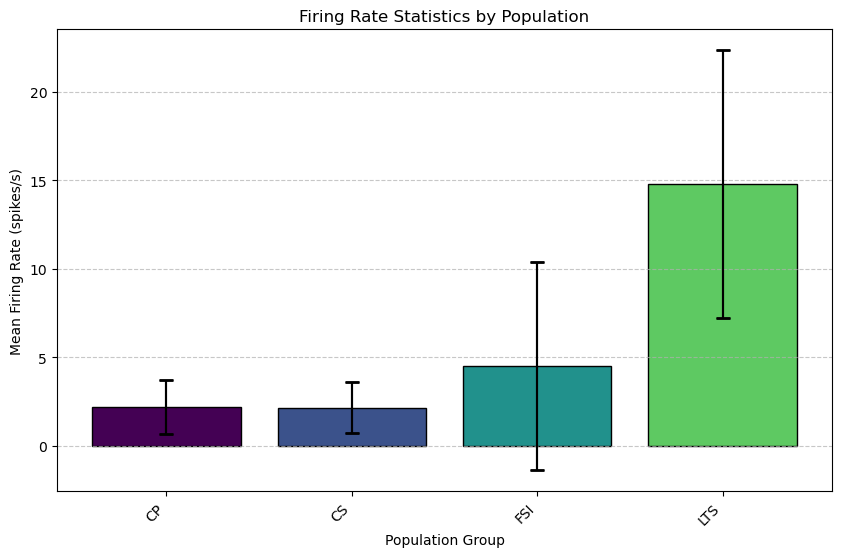

In [51]:
plot_firing_rate_pop_stats(pop_stats, groupby="pop_name")
plt.show()

Like the raster function you can also make some changes to the appearance of the plot if you want. Note both plotting functions have the ability only one is shown

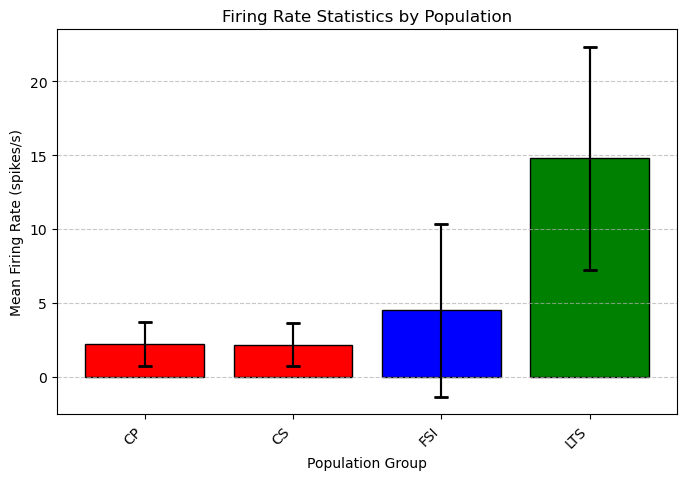

In [52]:
df = load_spikes_to_df(output_path, network_name="cortex", config=config_path,groupby='pop_name')
pop_stats,indivdual_stats = compute_firing_rate_stats(df, groupby="pop_name")

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_firing_rate_pop_stats(pop_stats, groupby='pop_name',color_map=color_map,ax=ax)

plt.show()

## compare_firing_over_times
You may want to compare the firing rates during different times during your simulation and compute if the firing is different. This can be useful if you are giving a changing input and want to see if you cells are responding differently.

In [53]:
from bmtool.analysis.spikes import compare_firing_over_times

spike_df = load_spikes_to_df("/home/gjgpb9/cortex_modeling/V1_Layer5/Run-Storage/final_result_2/block1/long/spikes.h5", "cortex",config='/home/gjgpb9/cortex_modeling/V1_Layer5/Model-Parameters/simulation_config_baseline.json')
compare_firing_over_times(spike_df,group_by='pop_name',time_window_1=(0,1000),time_window_2=(1000,2000))

Population: FSI
    Average firing rate in window 1: 4.60 Hz
    Average firing rate in window 2: 4.69 Hz
    U-statistic: 366210.50
    p-value: 0.40101877211121495
    Significant difference (p<0.05): No
Population: LTS
    Average firing rate in window 1: 2.14 Hz
    Average firing rate in window 2: 20.67 Hz
    U-statistic: 22456.00
    p-value: 6.613772768519174e-176
    Significant difference (p<0.05): Yes
Population: CP
    Average firing rate in window 1: 1.57 Hz
    Average firing rate in window 2: 2.68 Hz
    U-statistic: 9692980.50
    p-value: 1.629101314611588e-10
    Significant difference (p<0.05): Yes
Population: CS
    Average firing rate in window 1: 1.57 Hz
    Average firing rate in window 2: 2.44 Hz
    U-statistic: 9945849.00
    p-value: 1.0708612377729946e-18
    Significant difference (p<0.05): Yes
